In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from category_encoders import TargetEncoder
from xgboost import plot_importance

## Data Preparation

### 1. Load Data

In [2]:
train_data = pd.read_csv("./data/train.csv").reset_index(drop=True)
store_data = pd.read_csv("./data/store.csv").reset_index(drop=True)

/Users/sinarampe/opt/anaconda3/envs/mini_comp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 2. Data Exploration

### 3. Data Cleaning and Feature Engineering 

In [4]:
def add_time_features(df):
    """
    Converts "Date" from type string to datetime format.
    Creates a year, month, day, dayofweek and weekofyear column in the dataframe.
    """
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df.Date.dt.year - 2013
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day
    df["DayOfWeek"] = df.Date.dt.dayofweek
    df["WeekOfYear"] = df.Date.dt.isocalendar().week.astype(int)
    df = df.drop(labels="Date", axis=1)  # Drop the date column.
    return df

In [5]:
def drop_nans_nulls_closed(df):
    """
    Cleans dataframe by removing irrelevant information.
    """
    df = df[df["Open"] == 1]  # Drop rows where store is closed.
    df = df[df["Sales"] != 0]  # Keep rows where sales happened.
    df = df.dropna(
        subset=["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday", "Sales",]
    )  # Drop rows with missing values.
    try:
        df = df.drop(labels=["Customers"], axis=1)  # Drop customers.
    except:
        pass
    df["StateHoliday"].replace(
        {0.0: "0"}, inplace=True
    )  # Prepare feature for encoding.
    return df

In [6]:
def recode(df, var_list=[]):
    """
    Encodes categorical columns.
    """
    map_dict = {"0": 0, "a": 1, "b": 2, "c": 3, "d": 4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df

In [7]:
def month_to_str(df):
    """
    Creates a new column with "Month" as string.
    """
    map_dict = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sept",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    df["month_str"] = df.Month.map(map_dict)
    return df

In [8]:
def check_promo(row):
    """
    Creates a new column "PromoMonth", which indicates whether the actual month is a promo-month.
    """
    if (
        isinstance(row["PromoInterval"], str)
        and row["month_str"] in row["PromoInterval"]
    ):
        return 1
    else:
        return 0

In [9]:
train_data = add_time_features(train_data)
train_data = drop_nans_nulls_closed(train_data)

In [10]:
#  Merge train data with store data.
merged_train = pd.merge(train_data, store_data, how="left", on="Store")

In [11]:
merged_train = recode(merged_train, ["StoreType", "Assortment", "StateHoliday"])

In [12]:
merged_train = month_to_str(merged_train)

In [13]:
merged_train["PromoMonth"] = merged_train.apply(lambda row: check_promo(row), axis=1)

In [15]:
# Target encode "Store" into a new column.
encoder = TargetEncoder()
merged_train["Store_encoded"] = encoder.fit_transform(
    merged_train["Store"], merged_train["Sales"]
)

### 4. Load and prepare the holdout data

In [16]:
def drop_nn(df):
    """
    Cleans dataframe by removing irrelevant information.
    """
    df = df[df["Open"] == 1]
    df = df.dropna(subset=["Open"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    try:
        df = df.drop(labels=["Customers"], axis=1)  # Drop customers.
    except:
        pass
    return df

In [17]:
holdout_data = pd.read_csv("../minicomp-rossman/data/holdout_b29.csv")

In [18]:
holdout_data = holdout_data.rename(columns={"Unnamed: 0": "Id"})
holdout_data["Id"] = holdout_data["Id"] + 1

In [19]:
holdout_data = add_time_features(holdout_data)
holdout_data = drop_nn(holdout_data)

In [20]:
merged_holdout = pd.merge(holdout_data, store_data, how="left", on="Store")
merged_holdout = recode(merged_holdout, ["StoreType", "Assortment", "StateHoliday"])
merged_holdout = month_to_str(merged_holdout)
merged_holdout["PromoMonth"] = merged_holdout.apply(
    lambda row: check_promo(row), axis=1
)

In [36]:
# Apply target encoding
merged_holdout["Store_encoded"] = encoder.transform(merged_holdout["Store"])

## Modelling with Gradient Boosted Tree

### 1. Define parameters

In [37]:
params = {"objective": "reg:squarederror", "booster": "gbtree", "seed": 10}

In [38]:
target = "Sales"

my_features = [
    "Store",
    "Year",
    "Month",
    "Day",
    "WeekOfYear",
    "DayOfWeek",
    "StateHoliday",
    "SchoolHoliday",
    "CompetitionDistance",
    "Promo2",
    "StoreType",
    "Assortment",
    "Open",
    "Promo",
    "PromoMonth",
    "Store_encoded",
]

### 2. Run Model

In [40]:
dtrain = xgb.DMatrix(merged_train[my_features], label=merged_train["Sales"], enable_categorical=True)
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

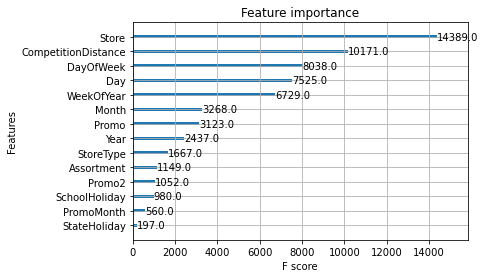

In [41]:
plot_importance(xgb_model)

In [43]:
xgb_holdout = xgb.DMatrix(merged_holdout[my_features])
pred = xgb_model.predict(xgb_holdout)

## Generate submission file

In [44]:
output = pd.DataFrame({"Id": holdout_data.Id, "Sales": pred})
output.to_csv("Submission.csv", index=False)

In [45]:
sub = pd.read_csv("Submission.csv")
sub.head()

,Id,Sales
0,1,7841.7310
1,2,9701.5040
2,3,5157.3564
3,4,17241.9670
4,5,7395.7270
